In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from itertools import chain
from sklearn.linear_model import LogisticRegression
from scipy.special import expit
from utils.utils import read_active_data_to_df, indiference_eta, calculate_min_v_max, is_statewise_dominated

In [2]:
root_path = os.path.join(os.getcwd(),) #os.path.join(os.path.dirname(__file__),)
subject_ids = [0,1]
dynamics = ['Additive','Multiplicative']

In [3]:
#read data
dfs = read_active_data_to_df(root_path = root_path, 
                             dynamics = dynamics, 
                             subject_ids = subject_ids)

In [4]:
#Dummy data
    
data = { 
  
 'x1' : [-250, -250, -250, -250, -250, -250],
 'x2' : [180,   222,  286,  400,  677, 290],
 'x3' : [0,     0,    0,    0,    0,   0], 
 'x4' : [0,     0,    0,    0,    0,   0],
 'w'  : [1000,  1000, 1000, 1000, 1000, 1000],
 'choice' : ['right', 'right', 'left', 'left', 'left', 'right']} 
    
df = pd.DataFrame(data) 
df 
df_copy = df.copy(deep=True)

choice_dict = {'right': 1, 'left': 0}

#loop by df is loop by columns, same as for column in booleandf.columns:
dfs = dict()
for ii, dynamic in enumerate(dynamics):
    tmp = dict()
    for jj in range(2):
        df_copy['choice'] = df['choice'].map(choice_dict)
        tmp[jj] = df_copy
    dfs[dynamic] = tmp

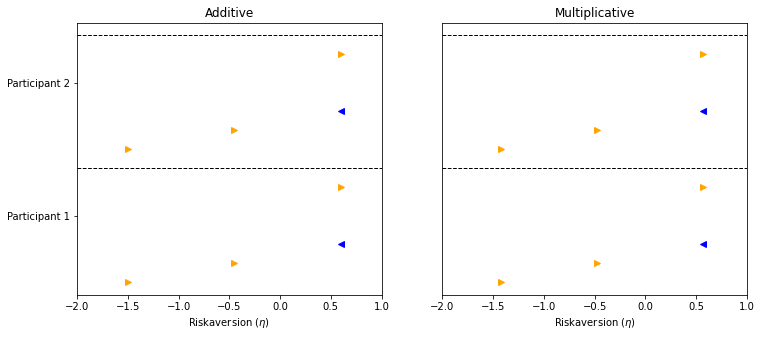

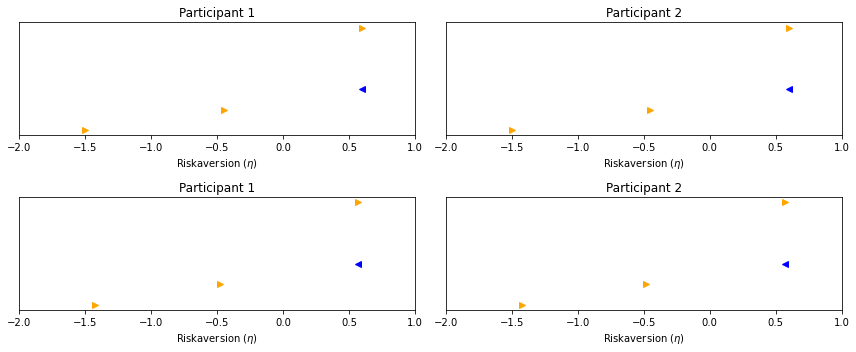

In [6]:
start_search = [-50,-5]

fig_dynamic, ax_dynamic = plt.subplots(1,len(dynamics),figsize = (12,5))
fig_subject, ax_subject = plt.subplots(len(subject_ids),len(dynamics),figsize = (12,5))

roots = list()
min_max = list()
for ii, dynamic in enumerate(dynamics):
    roots_dynamic = list()
    min_max_dynamic = list()
    
    tick_place = [0]
    tick_names = []
    trial_counter = 0
    for i, subject in enumerate(subject_ids):
        roots_subject = list()
        min_max_subject = list()
        
        df = dfs[dynamic][i]
        for jj, choice in enumerate(df['choice']):
            trial_counter += 1
            if is_statewise_dominated([[df['x1'][jj], df['x2'][jj]], [df['x3'][jj], df['x4'][jj]]]):
                continue
            
            root_dyn, func_dyn = indiference_eta(df['x1'][jj], df['x2'][jj], df['x3'][jj], df['x4'][jj], df['w'][jj], start_search[ii])
            if root_dyn is None:
                continue
                     
            min_max_dyn = calculate_min_v_max(root_dyn, func_dyn, choice=choice)
            
            roots_subject.append(root_dyn)
            min_max_subject.append(min_max_dyn['val'])
            
            ax_subject[ii,subject].plot(root_dyn, jj, marker=min_max_dyn['sign'], color = min_max_dyn['color'])
            ax_dynamic[ii].plot(root_dyn, trial_counter, marker=min_max_dyn['sign'], color = min_max_dyn['color'])
            
            ax_subject[ii,subject].axes.yaxis.set_visible(False)  
            ax_subject[ii,subject].set(xlabel='Riskaversion ($\eta$)', title = f'Participant {subject+1}', xlim = [-2,1])
            
        
        roots_dynamic.append(roots_subject)
        min_max_dynamic.append(min_max_subject)
        
        trial_counter += 1
        ax_dynamic[ii].axhline(trial_counter, linestyle='--', linewidth=1, color='k')
        tick_place.append(trial_counter - jj / 2)
        tick_names.append(f'Participant {subject + 1}')
        ax_dynamic[ii].set(xlabel = 'Riskaversion ($\eta$)', title = dynamic, xlim = [-2,1])
    
    roots.append(roots_dynamic)
    min_max.append(min_max_dynamic)
    if ii == 0:
        ax_dynamic[ii].set_yticks(tick_place[1:])
        ax_dynamic[ii].set_yticklabels(tick_names)
    else:
        ax_dynamic[ii].axes.yaxis.set_visible(False)

plt.tight_layout()
fig_dynamic.savefig('figs/indifference_eta_non_parametric.png')
fig_subject.savefig('figs/indifference_eta_non_parametric_subjectwise.png')
plt.show()

AttributeError: 'LogisticRegression' object has no attribute 'cov_params'

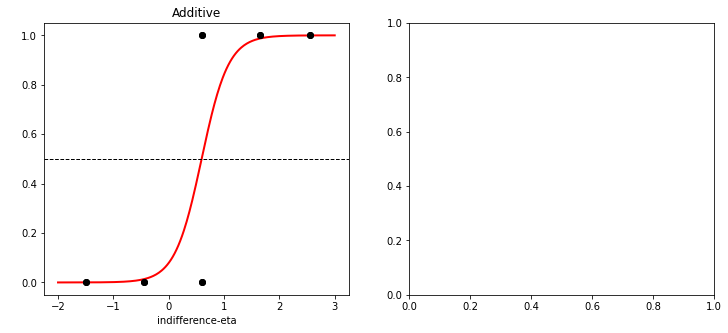

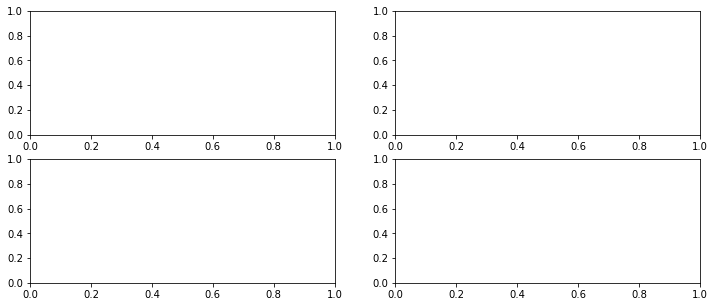

In [11]:
#Logistic regression

fig_dynamic, ax_dynamic = plt.subplots(1,len(dynamics),figsize = (12,5))
fig_subject, ax_subject = plt.subplots(len(subject_ids),len(dynamics),figsize = (12,5))

x_test = np.linspace(-2, 3, 300)
model = LogisticRegression(solver='liblinear', C=1e2, random_state=0)

for ii, dynamic in enumerate(dynamics):
    y = list(list(chain.from_iterable(min_max[ii])))
    x = list(list(chain.from_iterable(roots[ii])))
    x = np.reshape(x, (-1, 1))    
    
    ax_dynamic[ii].scatter(x, y, color="black", zorder=20, label = 'data')
    
    model_fit = model.fit(x, y)
    loss = expit(x_test * model_fit.coef_ + model_fit.intercept_).ravel()
    
    ax_dynamic[ii].plot(x_test, loss, color="red", linewidth=2, label='Logistic Regression Model')
    
    ax_dynamic[ii].axhline(y=0.5, linestyle='--', linewidth=1, color='black', label='50% interceptline')
    
    ax_dynamic[ii].set(ylabel=' ', xlabel='indifference-eta',
        title=dynamic)
    
    # estimate confidence interval for predicted probabilities
    cov = model.cov_params()
    gradient = (proba * (1 - proba) * X.T).T # matrix of gradients for each observation
    std_errors = np.array([np.sqrt(np.dot(np.dot(g, cov), g)) for g in gradient])
    c = 1.96 # multiplier for confidence interval
    upper = np.maximum(0, np.minimum(1, proba + std_errors * c))
    lower = np.maximum(0, np.minimum(1, proba - std_errors * c))
    
    ax_dynamic[ii].plot(x, lower, color='g')
    ax_dynamic[ii].plot(x, upper, color='g')


    
    for subject, _ in enumerate(subject_ids):
        y = min_max[ii][subject]
        x = roots[ii][subject]
        x = np.reshape(x, (-1, 1))
        ax_subject[ii, subject].scatter(x, y, color="black", zorder=20, label = 'data')
    
        model_fit = model.fit(x, y)
        loss = expit(x_test * model_fit.coef_ + model_fit.intercept_).ravel()

        ax_subject[ii, subject].plot(x_test, loss, color="red", linewidth=2, label='Logistic Regression Model')

        ax_subject[ii, subject].axhline(y=0.5, linestyle='--', linewidth=1, color='black', label='50% interceptline')

        ax_subject[ii, subject].set(ylabel=' ', xlabel='indifference-eta',
            title=f'Participant {subject+1}')
        
plt.tight_layout()
fig_dynamic.savefig('figs/indifference_eta_logistic_regression.png')
fig_subject.savefig('figs/indifference_eta_non_parametric_subjectwise_subjectwise.png')
plt.show()